# Exploring MoveNet model for keypoint dectection
The MoveNet model is a deep learning model developed by Google for real-time pose detection. It can identify key points on the human body in images and video streams.  
The model is **pre-trained**, therefore, there won't be any training done for this.

# Install Commandline and Dependencies
To run this code, you need to install the following Python libraries:
- **TensorFlow**: For loading and running the MoveNet model.
- **OpenCV**: For image and video processing.
- **Matplotlib**: For displaying images.
- **CV2**: For process images, capture webcam and video.

In [20]:
# pip install lib if needed
# !pip install tensorflow opencv-python matplotlib
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2

# Load model
MoveNet comes with different tflite model: multipose-lightning, singlepose-lightning, singlepose-thunder, etc. 
Here I am using the **singlepose-lightning tflite** because of its lightweight (compare to thunder) and the code is not applied to 2 or more pose at the same time. Althrough multipose-lightning/thunder can support to detect upto 6 people.
We can download the model using the commented code below.

In [21]:
# import kagglehub
# path = kagglehub.model_download("google/movenet/tfLite/singlepose-lightning-tflite-float16")

# print("Path to model files:", path)

Once finished, we load the model interpeter and initialized it.

In [22]:
# Initialize the TFLite interpreter
interpreter = tf.lite.Interpreter(model_path="singlepose-lightning-tflite-float16\\1\\4.tflite")
interpreter.allocate_tensors()

# Trying with one image
We could run the model with a image stream (video), however, let's start with one picture first.
The image will be loaded, displayed and pre-processed to fit into the model

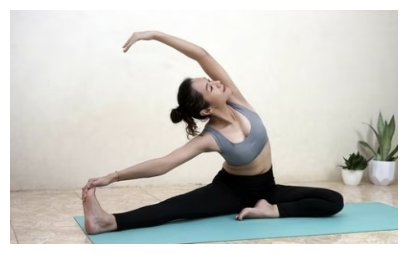

In [39]:
# Load image 
image_path = 'yoga.jpg'
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)
# and display
plt.figure(figsize=(5,5))
plt.imshow(image)
_ = plt.axis('off')

In [40]:
# Resize and pad the image to keep the aspect ratio and fit the expected size.
image = tf.image.resize_with_pad(np.expand_dims(image, axis=0), 192,192)            # expected input image should be 192 x 192 x 3 (for this model)
input_image = tf.cast(image, dtype=tf.uint8)                                        # TF lite want tensor type of uint8

# Setup input and output 
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_details

[{'name': 'serving_default_input:0',
  'index': 0,
  'shape': array([  1, 192, 192,   3]),
  'shape_signature': array([  1, 192, 192,   3]),
  'dtype': numpy.uint8,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

As we see the input details, the input shape should be 1, 192, 192, 3 with 1 being the batch and 192 being both width and height, therefore, resize is needed. 

Explanation the code for my future self:  
- `tf.io.read_file(image_path)`: Reads the image file from the specified path as a byte string.  
- `tf.expand_dims(image, axis=0)`: Expands the dimensions of the image tensor to add a batch dimension. This is often required for processing images in batches even if there is only one image, resulting in a shape of (1, height, width, channels).  
- `tf.cast(tf.image.resize_with_pad(X, 256, 256), dtype=tf.uint8)`: Resizes the image to 256x256 pixels while preserving the aspect ratio by adding padding if necessary. The resized image is then cast to integer type (uint8)  
- `get_input_details` and `get_output_details`: These methods provide information about the model's input and output tensors.
- `set_tensor`: Sets the input tensor with the preprocessed image.  
- `invoke`: Runs the model with the input tensor.  
- `get_tensor`: Retrieves the output, which contains the key points and their confidence scores.  

# Predict Human keypoints
Once we done with the input data, let's try to do some predictions along with visualizing keypoints

In [41]:
interpreter.set_tensor(input_details[0]['index'], np.array(input_image))    # set tensor 
interpreter.invoke()                                                        # start model
keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])  # predict keypoint with confidence score
keypoints_with_scores

array([[[[0.41255525, 0.52671266, 0.6094947 ],
         [0.39085186, 0.52093345, 0.58854806],
         [0.41570446, 0.5082187 , 0.44737947],
         [0.39435133, 0.51468796, 0.56262285],
         [0.44530797, 0.49138653, 0.76370776],
         [0.40450546, 0.58263034, 0.8575365 ],
         [0.5148368 , 0.49993482, 0.8188962 ],
         [0.30607003, 0.48703435, 0.84733343],
         [0.5964413 , 0.3953446 , 0.90976405],
         [0.26006064, 0.3733843 , 0.7512156 ],
         [0.6243214 , 0.2561368 , 0.6922997 ],
         [0.65737444, 0.6728752 , 0.76468104],
         [0.65935063, 0.5738763 , 0.7723909 ],
         [0.68393356, 0.8475064 , 0.829402  ],
         [0.7060122 , 0.4187056 , 0.7878938 ],
         [0.7055928 , 0.6651637 , 0.7216908 ],
         [0.7403602 , 0.24463028, 0.7819797 ]]]], dtype=float32)

Once `get_tensor` is called, we will received a bunch of array. These stand for x, y coordinate (by ratio) of keypoint with its confidence score.  
There are 17 keypoints: in the order of: [nose, left eye, right eye, left ear, right ear, left shoulder, right shoulder, left elbow, right elbow, left wrist, right wrist, left hip, right hip, left knee, right knee, left ankle, right ankle]

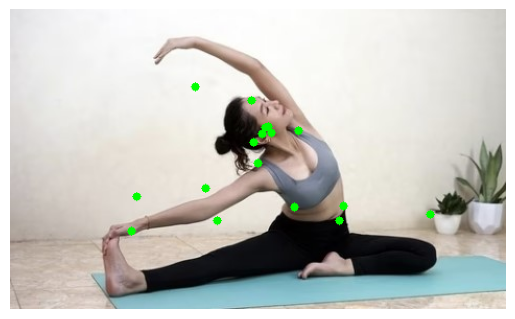

In [54]:
display = cv2.imread("yoga.jpg")
y, x, c = display.shape
shaped = np.squeeze(np.multiply(keypoints_with_scores, [y,x,1]))

for kp in shaped:
    ky, kx, kp_conf = kp
    if kp_conf > 0.4:
        cv2.circle(display, (int(kx), int(ky)), 4, (0, 255, 0), -1)

# Display the image with keypoints
plt.imshow(cv2.cvtColor(display, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


`cv2.circle`: Draws circles at the key points with a confidence score above confidence threshold(which is 4).  


# Draw connected edges 
Below is the list of edges that logically connected with each others (provided by tensorflow code)

In [27]:
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

Then display it with the edges.

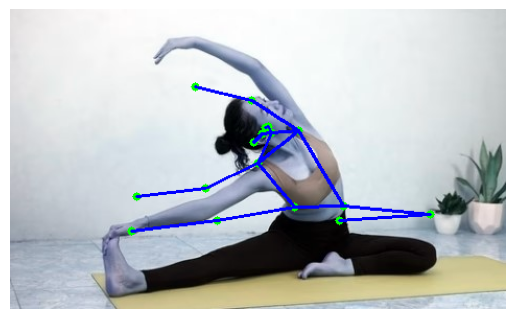

In [ ]:
y, x, c = display.shape
shaped = np.squeeze(np.multiply(keypoints_with_scores, [y,x,1]))

for edge, color in EDGES.items():
    p1, p2 = edge
    y1, x1, c1 = shaped[p1]
    y2, x2, c2 = shaped[p2]
    
    if (c1 > 0.4) & (c2 > 0.4):      
        cv2.line(display, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)

plt.imshow(display)
_ = plt.axis('off')

`cv2.line`: Draws lines between key points to represent connections based on predefined edges.  

# Trying with webcam
The code seem to work well with one picture. Next we just need to back the above code as methods to re-use it for stream of images

In [30]:
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 4, (0,255,0), -1) 

In [31]:
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)

With that, we can now do real-time detection with webcam.  
The code below will activate the webcam (if there is one) on the device. Hit **Q** to end the function.

In [32]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    # Reshape image
    img = frame.copy()
    img = tf.image.resize_with_pad(np.expand_dims(img, axis=0), 192,192)
    input_image = tf.cast(img, dtype=tf.uint8)
    
    # Setup input and output 
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Make predictions 
    interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
    interpreter.invoke()
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    
    # Drawing 
    draw_connections(frame, keypoints_with_scores, EDGES, 0.4)
    draw_keypoints(frame, keypoints_with_scores, 0.4)
    
    cv2.imshow('MoveNet Lightning', frame)
    
    if cv2.waitKey(10) & 0xFF==ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

`cv2.VideoCapture(0)`: Opens the default webcam.  
`cap.read()`: Captures frames from the webcam.  
`draw_keypoints` and `draw_connections`: Functions to draw key points and connections on each frame.   
`cap.release()` and `cv2.destroyAllWindows()`: Release the webcam and close any OpenCV windows.  

# Future improvement
There are more that we could improve the code as well as apply it into larger applications. Here are some that I can think of: 
- Intergrating with an exercise app would great reduce the risk of poor posture while doing resistance training
- Adding more robust error handling and validation for input images and webcam streams.